In [151]:
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import os
import shutil
import glob
from scipy import sparse

np.random.seed(2)

In [152]:
# randomly generate data 
N = 3 # number of training sample 
d = 2 # data dimension 
C = 3 # number of classes 

X = np.random.randn(d, N)
y = np.random.randint(0, 3, (N,))

In [153]:
# One-hot encoding
def convert_labels(y, C=C):
    """
    convert 1d label to a matrix label: each column of this 
    matrix coresponding to 1 element in y. In i-th column of Y, 
    only one non-zeros element located in the y[i]-th position, 
    and = 1 ex: y = [0, 2, 1, 0], and 3 classes then return

            [[1, 0, 0, 1],
             [0, 0, 1, 0],
             [0, 1, 0, 0]]
    """
    Y = sparse.coo_matrix((np.ones_like(y), (y, np.arange(len(y)))), shape = (C, len(y))).toarray()
    return Y 

Y = convert_labels(y)

In [154]:
def softmax_stable(X):
    X_exp = np.exp(X - np.max(X, axis=0, keepdims=True))
    return X_exp / np.sum(X_exp, axis=0)

def cost(X, Y, W):
    A = softmax_stable(W.T.dot(X))
    return -np.sum(Y*np.log(A))

def grad(X, Y, W):
    A = softmax_stable(W.T.dot(X))
    E = A - Y
    return X.dot(E.T)

def numerical_grad(X, Y, W, cost):
    eps = 1e-6
    g = np.zeros_like(W)
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W_p = W.copy()
            W_n = W.copy()
            W_p[i, j] += eps 
            W_n[i, j] -= eps
            g[i,j] = (cost(X, Y, W_p) - cost(X, Y, W_n))/(2*eps)
    return g 

W_init = np.random.rand(d, C)

g1 = grad(X, Y, W_init)
g2 = numerical_grad(X, Y, W_init, cost)

print(np.linalg.norm(g1 - g2))



6.516957294758181e-10


In [159]:
def softmax_regression(X, y, learning_rate=.05, tol=1e-4, epochs=10000):
    W = [W_init]
    C = W_init.shape[1]
    Y = convert_labels(y, C)
    it = 0
    N, d = X.shape[1], X.shape[0]

    count = 0
    check_w_after = 20
    while count < epochs:
        # mix data
        mix_id = np.random.permutation(N)
        for i in mix_id:
            xi = X[:, i].reshape(d, 1)
            yi = Y[:, i].reshape(C, 1)
            ai = softmax_stable(np.dot(W[-1].T, xi))
            W_new = W[-1] - learning_rate * xi.dot((ai - yi).T)
            count += 1
            if count % check_w_after == 0:
                if np.linalg.norm(W_new - W[-check_w_after]) < tol:
                    return W
            W.append(W_new)
    return W

def pred(W, X):
    return np.argmax(softmax_stable(W.T.dot(X)), axis=0)

In [160]:
# Creating data
means = [[2, 2], [8, 3], [3, 6]]
cov = [[1, 0], [0, 1]]
N = 500
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X2 = np.random.multivariate_normal(means[2], cov, N)

# each column is a datapoint
X = np.concatenate((X0, X1, X2), axis = 0).T 
# extended data
X = np.concatenate((np.ones((1, 3*N)), X), axis = 0)
C = 3

original_label = np.asarray([0]*N + [1]*N + [2]*N).T

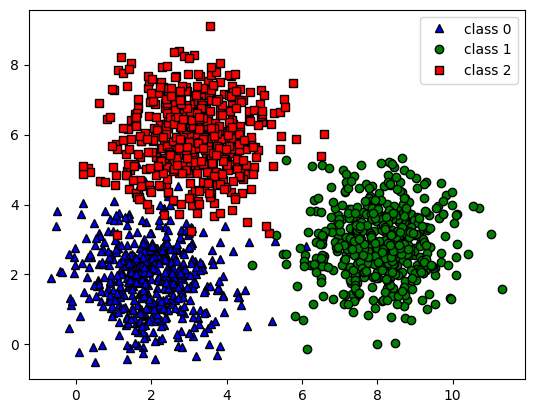

In [161]:
fig = plt.figure()
plt.plot(X0[:, 0], X0[:, 1], 'b^', markeredgecolor='black', label='class 0')
plt.plot(X1[:, 0], X1[:, 1], 'go', markeredgecolor='black', label='class 1')
plt.plot(X2[:, 0], X2[:, 1], 'rs', markeredgecolor='black', label='class 2')
plt.legend()
plt.show()

In [162]:
W_init = np.random.randn(X.shape[0], C)
W = softmax_regression(X, original_label, W_init)
print(W[-1].shape)

(3, 3)


In [163]:
xx = np.linspace(-2, 10, 500)
yy = np.linspace(-2, 10, 500)
xx, yy = np.meshgrid(xx, yy)
data = np.array([xx.flatten(), yy.flatten()])
data = np.concatenate((np.ones((1, data.shape[-1])), data), axis=0)

In [181]:
print(data.shape)

(3, 250000)


In [172]:
best_weight = W[-1]
weight_line_1 = 2 * best_weight[:, 0] - np.sum(best_weight, axis=0)
rs = weight_line_1.T.dot(data).astype(np.int8)
x_line_1, y_line_1 = data[1, :][rs == 0], data[-1, :][rs == 0]

In [165]:
x_line_1 = x_line_1.astype(np.int32)
y_line_1 = y_line_1.astype(np.int32)

In [173]:
# Get the indices that would sort x_line_1
sorted_indices = np.argsort(x_line_1)

# Sort x_line_1 and y_line_1 based on the sorted indices
x_line_1_sorted = x_line_1[sorted_indices]
y_line_1_sorted = y_line_1[sorted_indices]

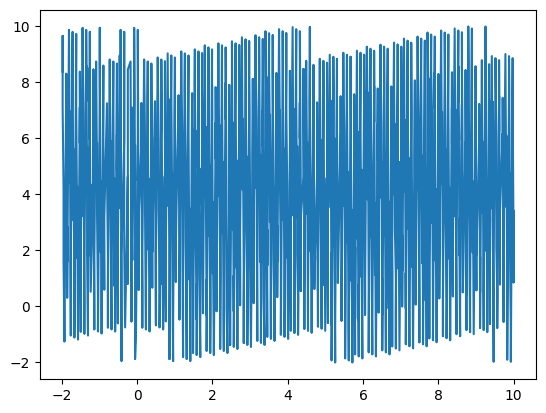

In [178]:
fig = plt.figure()
plt.plot(x_line_1_sorted, y_line_1_sorted)
plt.show()

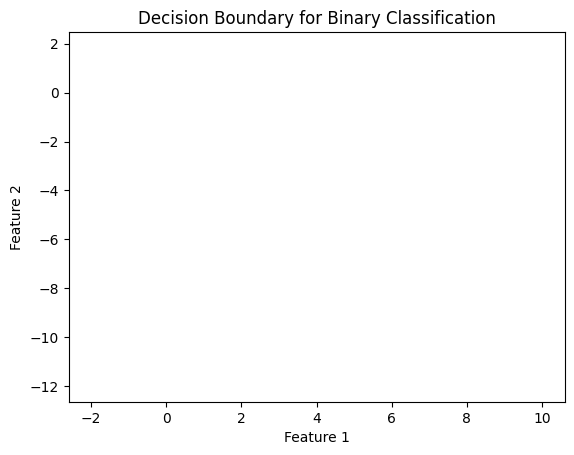

In [183]:
best_weight = W[-1]

# Generate data for decision boundary
xx = np.linspace(-2, 10, 500)
yy = np.linspace(-2, 10, 500)
xx, yy = np.meshgrid(xx, yy)
data = np.array([np.ones(xx.size), xx.flatten(), yy.flatten()])

# Calculate decision boundary line
weight_line_1 = best_weight[:, 0]
decision_boundary = - (weight_line_1[0] + weight_line_1[1] * xx) / weight_line_1[2]

# Plot decision boundary
fig = plt.figure()
plt.plot(xx, decision_boundary, label='Decision Boundary', color='red')

# Scatter plot of the data points
#for class_label in np.unique(original_label):
    #plt.scatter(X[1, original_label == class_label], X[2, original_label == class_label], label=f'Class {class_label}')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Decision Boundary for Binary Classification')
#plt.legend()
plt.show()

## Reference
https://machinelearningcoban.com/2017/02/17/softmax/